### Codelab RPPG with Mediapipe

Using method (Plane Orthogonal to Skin) for detcting the heart beat from the heart signal contactless based on the skin color

In [4]:
## Importing Dependencies
import numpy as np
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt
import os
from glob import glob
import scipy.signal as signal

### The POS Method Overview:

The POS (Plane Orthogonal to Skin) method is a technique used to estimate heart rate by analyzing the color changes in the skin, which occur as blood flows through the vessels and causes slight color shifts. The method works by processing a sequence of video frames using a series of steps, including normalization, projection, and tuning, to extract the periodic signal corresponding to heart rate.

Ref. 
- [Overview](https://chatgpt.com/share/674744c4-3508-800c-b35d-e7d57c56eda6)
- [Ref. Paper](https://pure.tue.nl/ws/files/31563684/TBME_00467_2016_R1_preprint.pdf)


In [17]:
## Core method Cpu POS 
def cpu_POS(signal, **kargs):
    """
    POS method on CPU using Numpy.

    The dictionary parameters are: {'fps':float}.

    Wang, W., den Brinker, A. C., Stuijk, S., & de Haan, G. (2016). Algorithmic principles of remote PPG. IEEE Transactions on Biomedical Engineering, 64(7), 1479-1491. 
    """
    """
    eps: A small constant (10^-9) used to prevent division by zero in normalization steps.
    X: The input signal, which is a 3D array where:
    e: Number of estimators or regions in the frame (like different parts of the face).
    c: Color channels (3 for RGB).
    f: Number of frames.
    w: Window length, determined by the camera's frame rate (fps). For example, at 20 fps, w would be 32 (which corresponds to about 1.6 seconds of video).
    """
    eps = 10**-9
    X = signal
    e, c, f = X.shape # Number of estimators, color channels, and frames
    w = int(1.6 * kargs['fps']) # Window length in frames

    """
    P: A fixed 2x3 matrix used for the projection step. It defines how to transform the color channels (RGB) into a new space.
    Q: This is a stack of the matrix P repeated e times, where each P corresponds to an estimator (region of interest) in the video.
    """
    P = np.array([[0, 1, -1], [-2, 1, 1]])
    Q = np.stack([P for _ in range(e)], axis = 0)

    """
    H: A matrix to store the estimated heart rate signal over time for each estimator.
    n: The current frame in the sliding window.
    m: The start index of the sliding window (calculating which frames are part of the current window).
    """
    H = np.zeros((e, f))
    for n in np.arange(w, f):
        # Start index of sliding window 
        m = n - w + 1

        """
        Temporal Normalization (Equation 5 from the paper): This step ensures that the signal is invariant to global lighting changes and other noise factors.
        """
        Cn = X[:, :, m:(n+1)]
        M = 1.0 / (np.mean(Cn, axis = 2) + eps)
        M = np.expand_dims(M, axis=2) # shape [e, c, w]
        Cn = np.multiply(Cn, M)

        """
        Projection (Equation 6 from the paper): This step transforms the RGB values into a space where the signal from blood flow (heart rate) is more distinct.
        """
        S = np.dot(Q, Cn)
        S = S[0, :, :, :]
        S = np.swapaxes(S, 0, 1) 

        """
        Tuning (Equation 7 from the paper): This step adjusts the projected components to make the heart rate signal clearer.
        """
        S1 = S[:, 0, :]
        S2 = S[:, 1, :]
        alpha = np.std(S1, axis=1) / (eps + np.std(S2, axis=1))
        alpha - np.expand_dims(alpha, axis=1)
        Hn = np.add(S1, alpha * S2)
        Hnm = Hn - np.expand_dims(np.mean(Hn, axis=1), axis=1)

        """
        Overlap-Adding (Equation 8 from the paper): This step combines the processed signals from each frame to form the final output heart rate signal.
        """
        H[:, m:(n + 1)] = np.add(H[:, m:(n + 1)], Hnm)  # Add the tuned signal to the output matrix

    return H

## Overall Step of POS
1. Initialization:
The code initializes necessary variables, including a small constant eps to prevent division by zero, and extracts the dimensions of the input signal X, which represents the color signal over time.

2. Sliding Window Setup:
A sliding window approach is employed, where a window of frames (w) slides over the entire sequence. This window is used to analyze temporal changes in the color signal.

3. Projection Matrix Preparation:
A fixed projection matrix P is defined, which is then replicated e times (where e is the number of estimators or regions of interest) to form the matrix Q. This matrix is used to project the color signal into a space that enhances the pulsatile component associated with heart rate.

4. Signal Processing Loop:
For each position of the sliding window, the code performs the following steps:
    - Temporal Normalization:
    The color signal within the window is normalized to account for global lighting variations and motion artifacts.
    - Projection:
    The normalized signal is projected using the matrix Q to enhance the pulsatile component.
    - Signal Tuning:
    The projected signal is tuned by adjusting the contributions of different components to improve the heart rate signal.
    - Detrending:
    The mean of the tuned signal is subtracted to remove low-frequency components, isolating the high-frequency pulsatile signal.
    - Overlap-Adding:
    The processed signal is added to the output matrix H, which accumulates the heart rate signal over time.

5. Output:
After processing all frames, the output matrix H contains the estimated heart rate signal for each estimator over time.


### Mediapipe Solution Face Detection

Ref. [Link](https://github.com/google-ai-edge/mediapipe/blob/master/docs/solutions/face_detection.md)

> Collection of detected faces, where each face is represented as a detection proto message that contains a bounding box and 6 key points (right eye, left eye, nose tip, mouth center, right ear tragion, and left ear tragion). The bounding box is composed of xmin and width (both normalized to [0.0, 1.0] by the image width) and ymin and height (both normalized to [0.0, 1.0] by the image height). Each key point is composed of x and y, which are normalized to [0.0, 1.0] by the image width and height respectively.



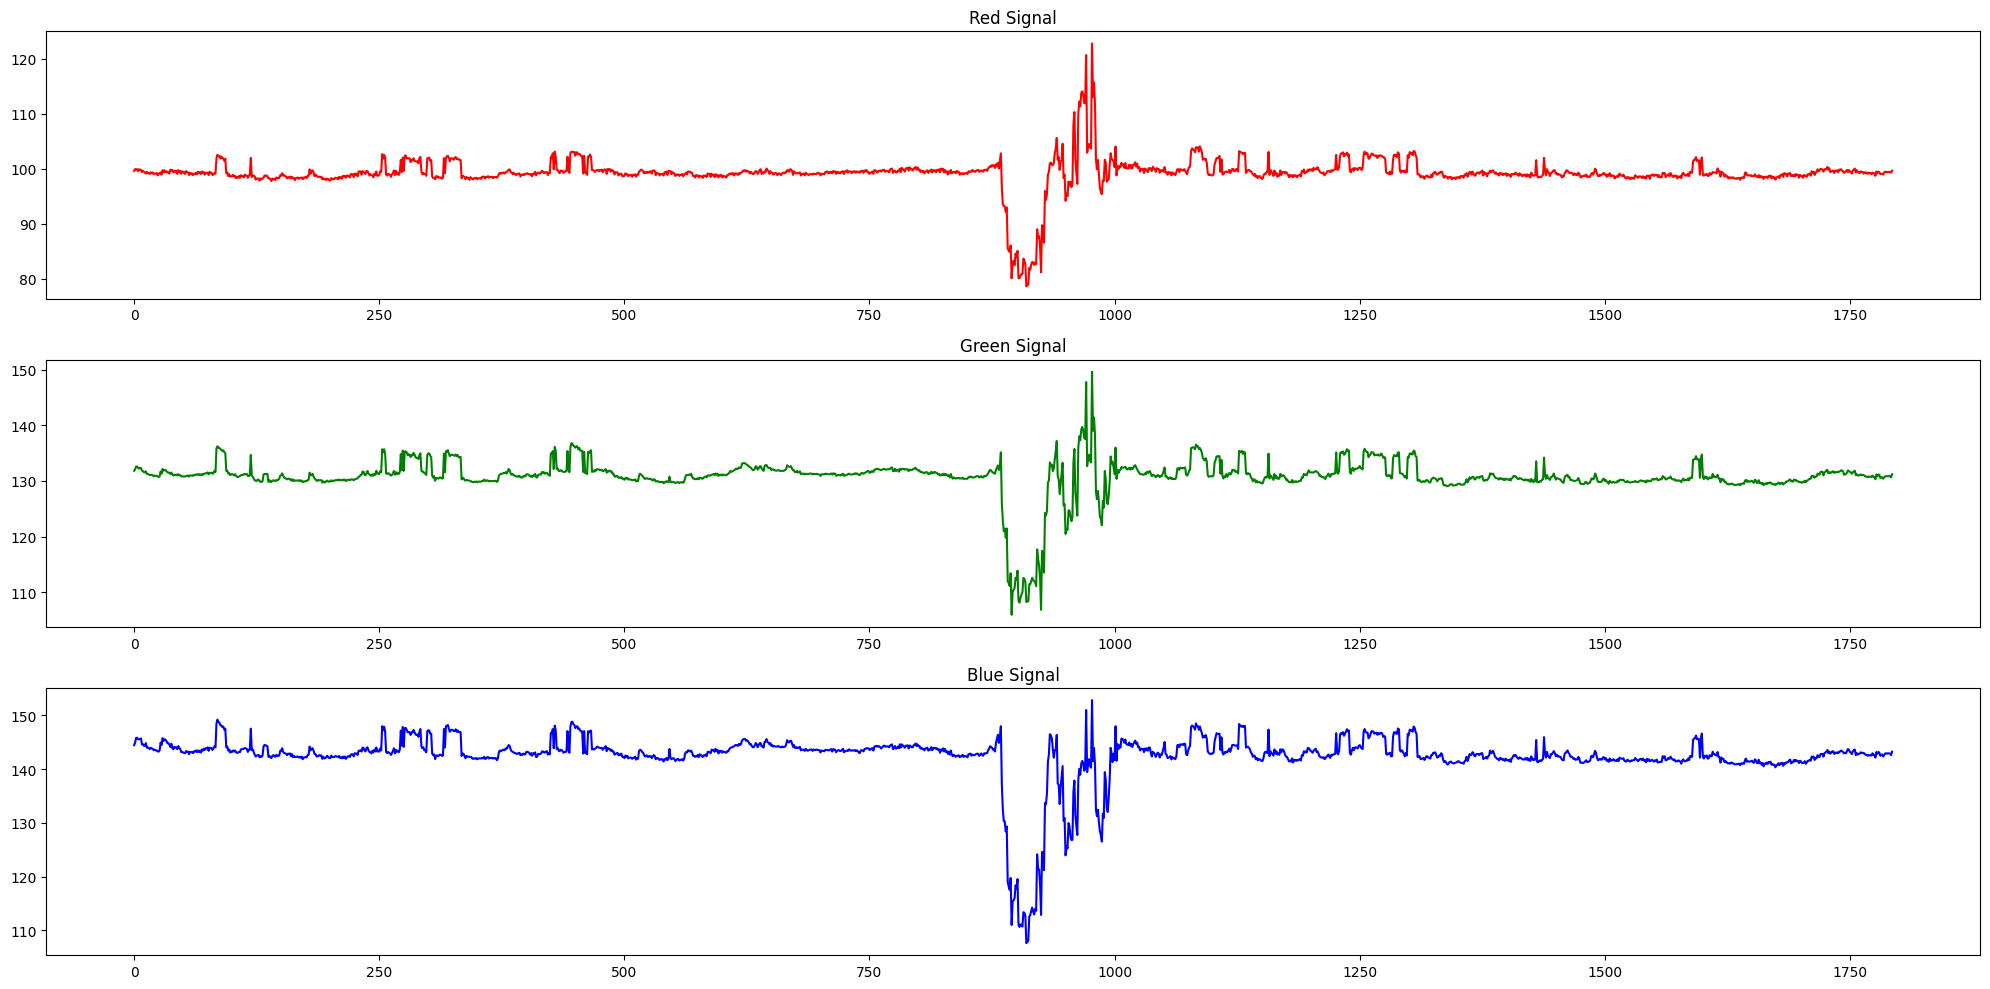

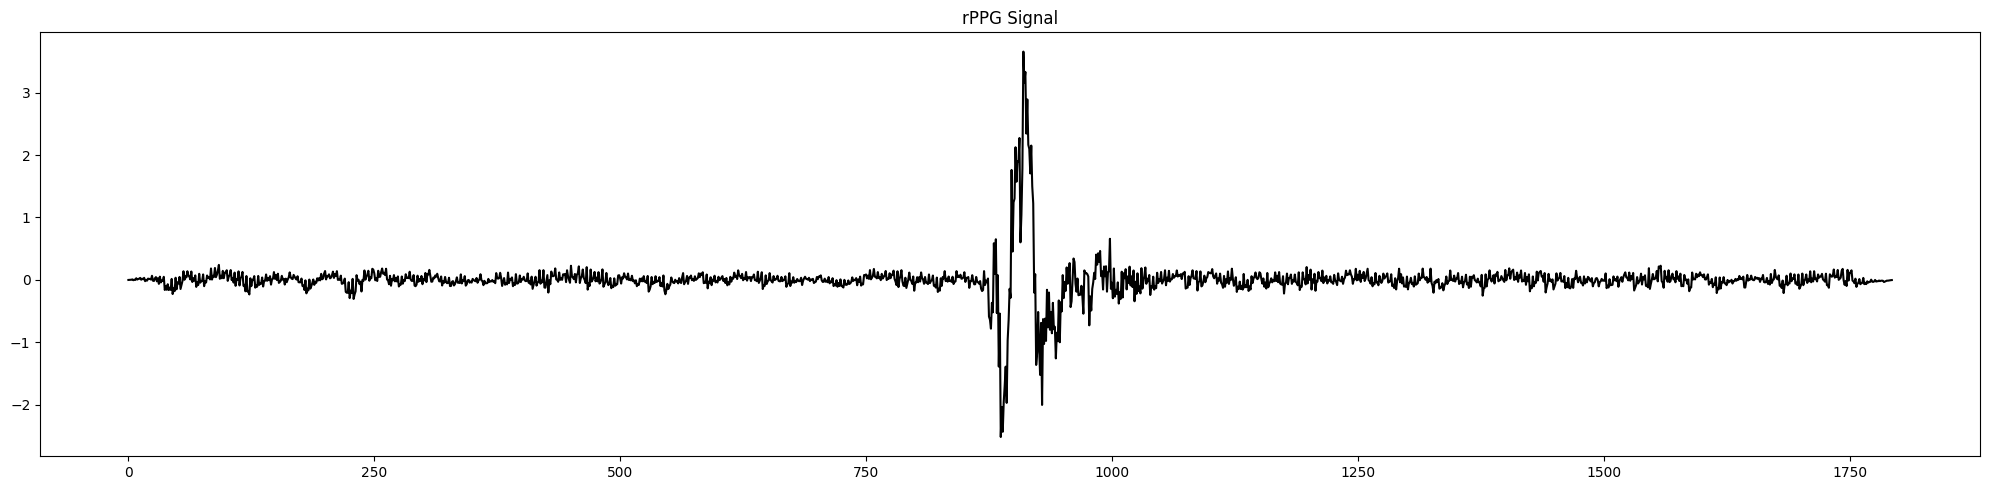

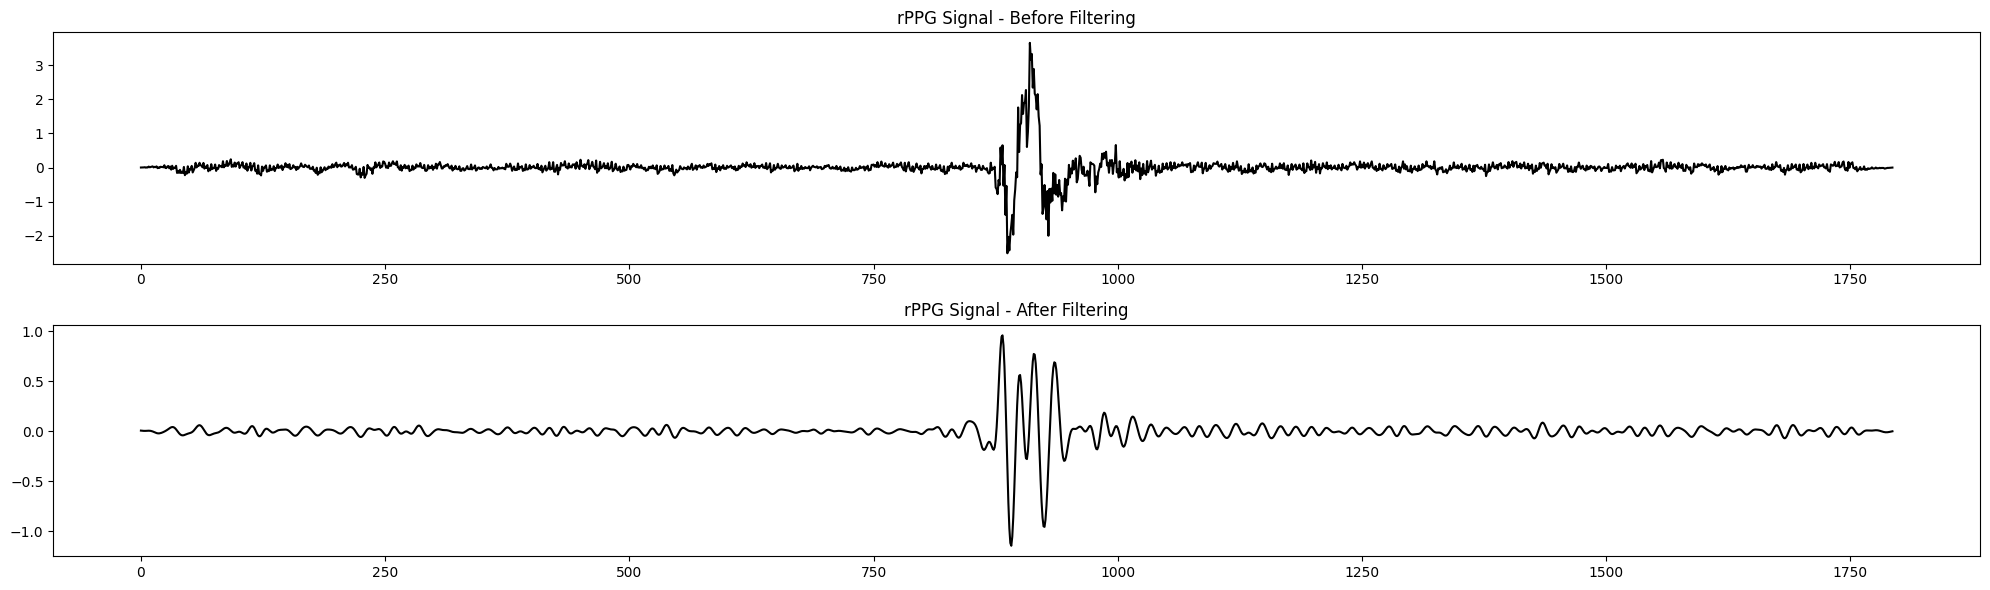

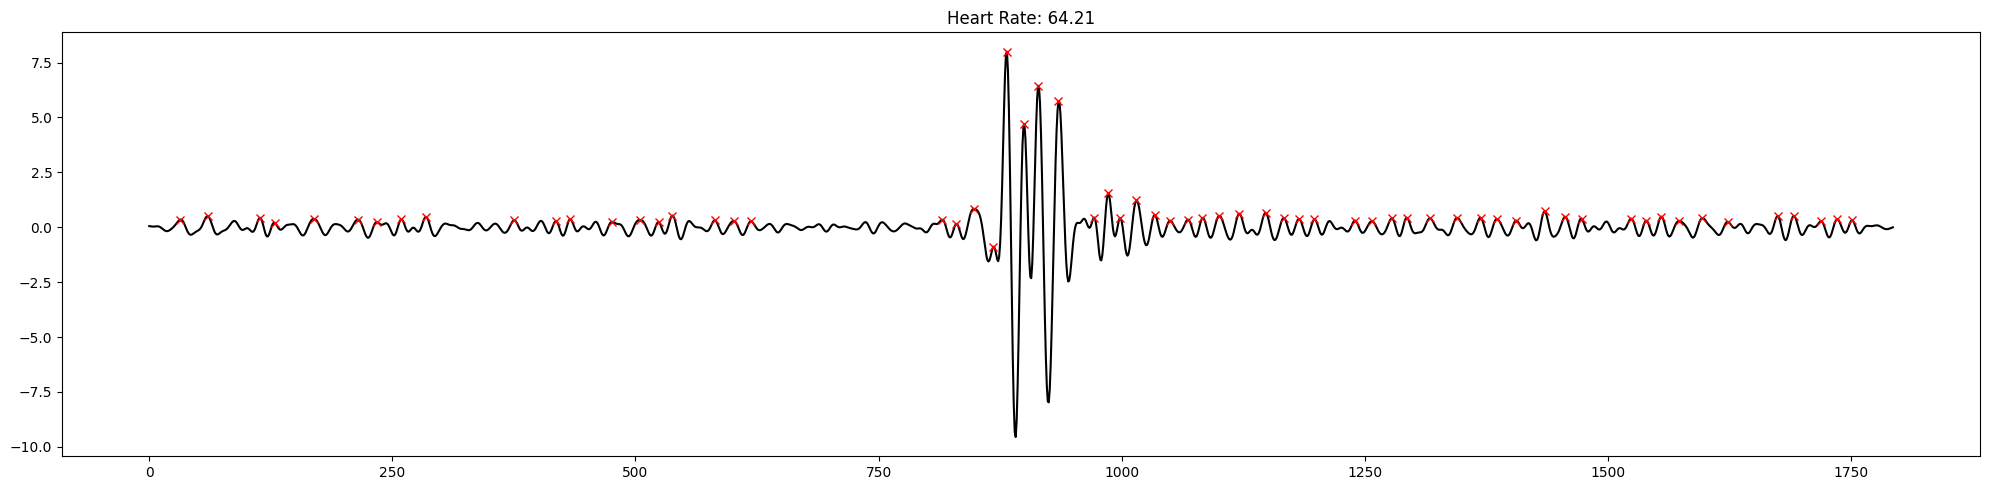

In [18]:
def main():
    # 1. Inisialisasi MediaPipe Face Detection
    mp_face_detection = mp.solutions.face_detection
    mp_drawing = mp.solutions.drawing_utils
    face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

    # 2. Memuat video dan melakukan perulangan
    ## Load Video
    video_path = os.path.join('sample-renamed.mp4')
    cap = cv2.VideoCapture(video_path)
    
    # 2.1 Mempersiapkan beberapa variabel
    r_signal, g_signal, b_signal = [], [], []
    f_count = 0
    f_total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # 2.2 Perulangan Utama
    try:
        while cap.isOpened():
            print(f'Processing Frame {f_count}/{f_total}', end='\r')
            ret, frame = cap.read()
            
            ### 3. Mendeteksi area wajah menggunakan mediapipe
            
            ### 3.1 Mengkonversi frame ke RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            ### 3.2 Memproses frame menggunakan face_detection
            results = face_detection.process(frame_rgb)
            
            if results.detections: # If there are faces detected
                for detection in results.detections: # Loop through all the detected faces
                    ### 3.3 Mendapatkan bounding box dari wajah
                    bbox = detection.location_data.relative_bounding_box
                    ### 3.4 Mendapatkan lebar dan tinggi frame
                    h, w, _ = frame.shape
                    ### 3.5 Mengkonversi bounding box ke koordinat piksel
                    x, y = int(bbox.xmin * w), int(bbox.ymin * h)
                    ### 3.6 Mengkonversi lebar dan tinggi bounding box ke koordinat piksel
                    width, height = int(bbox.width * w), int(bbox.height * h)
                    
                    ### 3.7 Melakukan penyesuaian pada bounding box
                    bbox_size_from_center = 70
                    
                    bbox_center_x = x + width // 2
                    bbox_center_y = y + height // 2
                    new_x = bbox_center_x - bbox_size_from_center
                    new_y = bbox_center_y - bbox_size_from_center
                    new_width = bbox_size_from_center * 2
                    new_height = bbox_size_from_center * 2
                    
                    ### 3.8 Menggambar bounding box pada frame
                    cv2.rectangle(frame, (new_x, new_y), (new_x + new_width, new_y + new_height), (0, 255, 0), 2)
                    
                    ### 4 Mendapatkan nilai rata-rata piksel dari ROI dan menambahkannya ke signal
                    roi = frame[new_y:new_y+new_height, new_x:new_x+new_width]
                    r_signal.append(np.mean(roi[:, :, 0]))
                    g_signal.append(np.mean(roi[:, :, 1]))
                    b_signal.append(np.mean(roi[:, :, 2]))
            
            if not ret:
                break
            # cv2.imshow('frame', frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
            f_count += 1
        cap.release()
        cv2.destroyAllWindows()
    
    except Exception as e:
        cap.release()
        cv2.destroyAllWindows()
    
    # 5. Menampilkan grafik sinyal
    ax, fig = plt.subplots(3, 1, figsize=(20, 10))
    fig[0].plot(r_signal, color='red')
    fig[0].set_title('Red Signal')
    fig[1].plot(g_signal, color='green')
    fig[1].set_title('Green Signal')
    fig[2].plot(b_signal, color='blue')
    fig[2].set_title('Blue Signal')
    plt.tight_layout()
    plt.show()
    
    
    # 6. Menghitung rPPG menggunakan Metode POS
    rgb_signals = np.array([r_signal, g_signal, b_signal])
    rgb_signals = rgb_signals.reshape(1, 3, -1)
    rppg_signal = cpu_POS(rgb_signals, fps=30)
    rppg_signal = rppg_signal.reshape(-1)
    
    # 6.1 Menampilkan grafik Sinyal rPPG
    plt.figure(figsize=(20, 5))
    plt.plot(rppg_signal, color='black')
    plt.title('rPPG Signal')
    plt.tight_layout()
    plt.show()
    
    # 7. Memfilter Sinyal rPPG
    fs = 30; lowcut = 0.9; highcut = 2.4; order = 3
    b, a = signal.butter(order, [lowcut, highcut], btype='band', fs=fs)
    filtered_rppg = signal.filtfilt(b, a, rppg_signal)
    
    fig, ax = plt.subplots(2, 1, figsize=(20, 6))
    ax[0].plot(rppg_signal, color='black')
    ax[0].set_title('rPPG Signal - Before Filtering')
    ax[1].plot(filtered_rppg, color='black')
    ax[1].set_title('rPPG Signal - After Filtering')
    plt.tight_layout()
    plt.show()
    
    
    # 8. Menghitung Heart Rate
    
    ## 8.1 Normalisasi Sinyal
    filtered_rppg = (filtered_rppg - np.mean(filtered_rppg)) / np.std(filtered_rppg)
    
    
    ## 8.2 Mencari puncak sinyal
    peaks, _ = signal.find_peaks(
        x=filtered_rppg,
        prominence=0.5,
    )
    
    ## 8.3 Menghitung heart rate
    heart_rate = 60 * len(peaks) / (len(filtered_rppg) / fs)
    
    ## 8.4 Menampilkan grafik puncak sinyal
    plt.figure(figsize=(20, 5))
    plt.plot(filtered_rppg, color='black')
    plt.plot(peaks, filtered_rppg[peaks], 'x', color='red')
    plt.title(f'Heart Rate: {heart_rate:.2f}')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

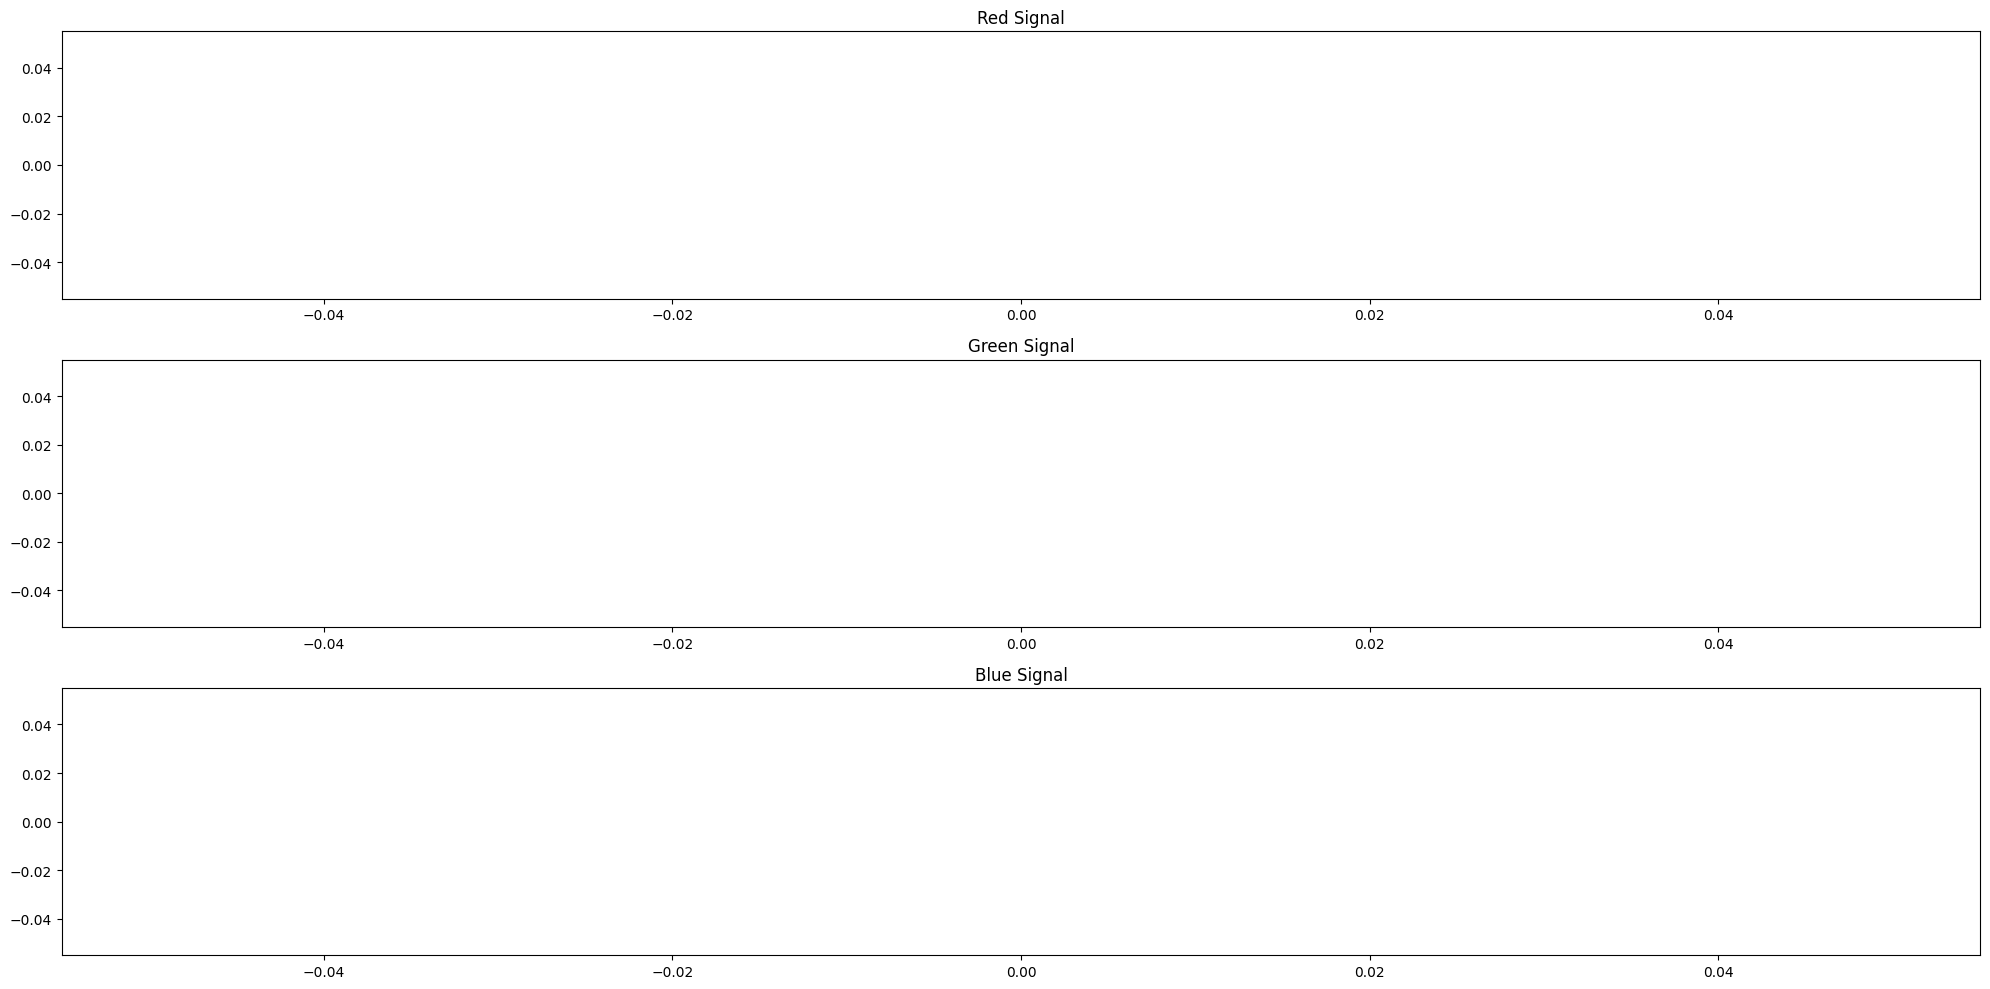

In [19]:
## Display Signal And Doing RPPG
ax, fig = plt.subplots(3, 1, figsize=(20, 10))
fig[0].plot(r_signal, color='red')
fig[0].set_title('Red Signal')
fig[1].plot(g_signal, color='green')
fig[1].set_title('Green Signal')
fig[2].plot(b_signal, color='blue')
fig[2].set_title('Blue Signal')
plt.tight_layout()
plt.show()


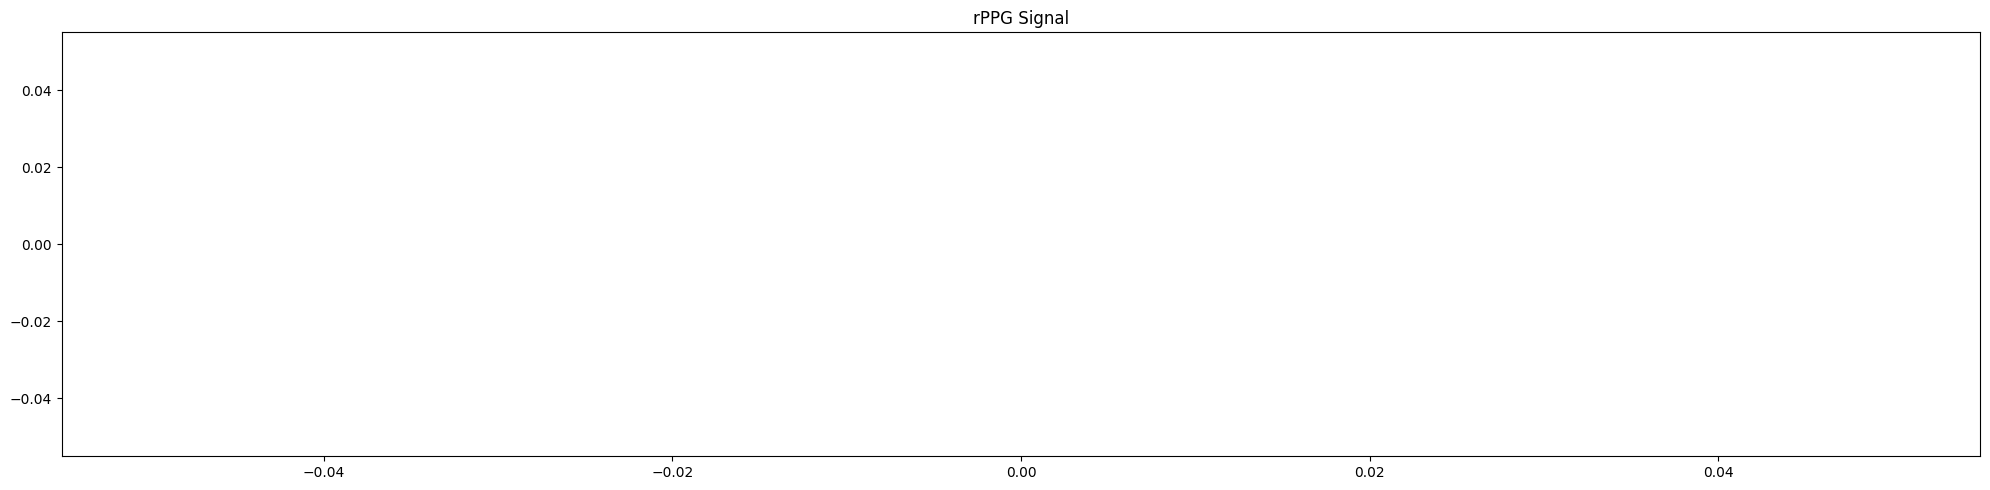

In [20]:
## Calculating the rPPG using POS
rgb_signals = np.array([r_signal, g_signal, b_signal])
rgb_signals = rgb_signals.reshape(1, 3, -1)
rppg_signal = cpu_POS(rgb_signals, fps=30)
rppg_signal = rppg_signal.reshape(-1)

## Show rPPG signal
plt.figure(figsize=(20, 5))
plt.plot(rppg_signal, color='black')
plt.title('rPPG Signal')
plt.tight_layout()
plt.show()


In [21]:
## Filtering rPPG Signal
fs = 30; lowcut = 0.9; highcut = 2.4; order = 3
b, a = signal.butter(order, [lowcut, highcut], btype='band', fs=fs)
filtered_rppg = signal.filtfilt(b, a, rppg_signal)

fig, ax = plt.subplots(2, 1, figsize=(20, 6))
ax[0].plot(rppg_signal, color='black')
ax[0].set_title('rPPG Signal - Before Filtering')
ax[1].plot(filtered_rppg, color='black')
ax[1].set_title('rPPG Signal - After Filtering')
plt.tight_layout()
plt.show()


ValueError: The length of the input vector x must be greater than padlen, which is 21.

In [ ]:
## Calculating the Heart Rate
## 8.1 Normalisasi Sinyal
filtered_rppg = (filtered_rppg - np.mean(filtered_rppg)) / np.std(filtered_rppg)


## 8.2 Mencari puncak sinyal
peaks, _ = signal.find_peaks(
    x=filtered_rppg,
    prominence=0.5,
)

## 8.3 Menghitung heart rate
heart_rate = 60 * len(peaks) / (len(filtered_rppg) / fs)

## 8.4 Menampilkan grafik puncak sinyal
plt.figure(figsize=(20, 5))
plt.plot(filtered_rppg, color='black')
plt.plot(peaks, filtered_rppg[peaks], 'x', color='red')
plt.title(f'Heart Rate: {heart_rate:.2f}')
plt.tight_layout()
plt.show()
